In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 1. Analyse des données

# 2. Prepocessing

## 1. Importation des données

In [3]:
# Importer les données
data_path="./data.csv"
data = pd.read_csv(data_path, sep=';')

# Convertir la features date en deux features mois et année
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].apply(lambda time: time.year)
data['month'] = data['date'].apply(lambda time: time.month)
data=data.drop('date', axis=1)

## 2. Drop des lignes mal renseignées

In [4]:
features_cause = [col for col in data.columns if col.startswith('prct')]
somme_pourcentage=data[features_cause].sum(axis=1)
data = data.loc[(somme_pourcentage >= 99.9) & (somme_pourcentage <= 100.1)]

## 3. Frequency encoding des variables catégorielles

In [ ]:
# Séparer les données d'entraînement et de test
train_data = data[data['year'] < 2023]
test_data = data[data['year'] == 2023]

# Frequency encoding des gares
frequency_encoding = train_data['gare_depart'].value_counts(normalize=True)
train_data['gare_depart_encoded'] = train_data['gare_depart'].map(frequency_encoding)
train_data['gare_arrivee_encoded'] = train_data['gare_arrivee'].map(frequency_encoding)
test_data['gare_depart_encoded'] = test_data['gare_depart'].map(frequency_encoding)
test_data['gare_arrivee_encoded'] = test_data['gare_arrivee'].map(frequency_encoding)

# Colonnes d'entrée
features = ['year', 'month', 'gare_depart_encoded', 'gare_arrivee_encoded', 'nb_train_prevu','duree_moyenne']

# Colonnes cible
target = 'retard_moyen_arrivee'

X_train_data=train_data[features]
y_train_data=train_data[target]

X_test_data=test_data[features]
y_test_data=test_data[target]

## 4. Clustering par lignes pour les causes

In [6]:
features_cause = [col for col in data.columns if col.startswith('prct')]
data['couple_gares'] = [f"{row.gare_depart}-{row.gare_arrivee}" for row in data.itertuples()]

data_clustering = data[data['year'] < 2023]
data_clustering = data_clustering.groupby('couple_gares').agg({'prct_cause_externe': 'mean',
                                         'prct_cause_infra': 'mean',
                                         'prct_cause_gestion_trafic': 'mean',
                                         'prct_cause_materiel_roulant': 'mean',
                                         'prct_cause_gestion_gare': 'mean',
                                         'prct_cause_prise_en_charge_voyageurs': 'mean'}).reset_index()

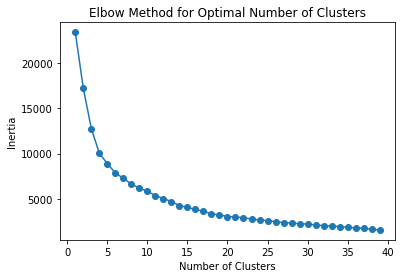

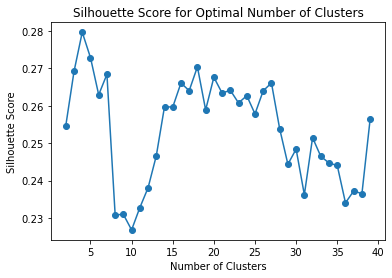

In [7]:
inertia = []

# Define a range of cluster numbers to test
cluster_range = range(1, 40)

# Calculate inertia for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Create an empty list to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
cluster_range = range(2, 40)  # Start with a minimum of 2 clusters

# Calculate silhouette scores for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
    silhouette_avg = silhouette_score(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

Considérer 18 cluster semble être un choix pertinent

In [9]:
# Fit k-means on 18 clusters
kmeans = KMeans(n_clusters=18)
cluster_labels = kmeans.fit_predict(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
data_clustering['cluster'] = cluster_labels

In [ ]:
barycentres = data_clustering.groupby('cluster')[features_cause].mean().reset_index()

# Dans le dataset de test, on ajoute les pourcentage de causes obtenues via clustering
for col in features_cause:
    test_data[col]=None

for i in range(len(test_data)):
    instance=test_data.iloc[i]
    cluster_ligne=int(data_clustering["cluster"][data_clustering.couple_gares==instance["couple_gares"]])
    for col in features_cause:
        test_data.at[i, col]=barycentres[col][barycentres.cluster==cluster_ligne]

In [ ]:
# Frequency encoding des gares
frequency_encoding = train_data['gare_depart'].value_counts(normalize=True)
train_data['gare_depart_encoded'] = train_data['gare_depart'].map(frequency_encoding)
train_data['gare_arrivee_encoded'] = train_data['gare_arrivee'].map(frequency_encoding)
test_data['gare_depart_encoded'] = test_data['gare_depart'].map(frequency_encoding)
test_data['gare_arrivee_encoded'] = test_data['gare_arrivee'].map(frequency_encoding)

# Colonnes d'entrée
features = ['year', 'month', 'gare_depart_encoded', 'gare_arrivee_encoded', 'nb_train_prevu','duree_moyenne']
features_avec_causes=features+features_cause
# Colonnes cible
target = 'retard_moyen_arrivee'

X_train_data=train_data[features_avec_causes]
y_train_data=train_data[target]

X_test_data=test_data[features_avec_causes]
y_test_data=test_data[target]


## 5. Clustering pour encodage des gares de départ et d'arrivée

### Gare de départ

In [10]:
data_clustering_depart = data[data['year'] < 2023]
data_clustering_depart = data_clustering_depart.groupby('gare_depart').agg({'duree_moyenne': 'mean',
                                         'retard_moyen_arrivee': 'mean',
                                         'nb_train_prevu': 'mean',
                                         'nb_train_depart_retard': 'mean',
                                         'retard_moyen_depart': 'mean',
                                         'retard_moyen_tous_trains_depart' :'mean'}).reset_index()

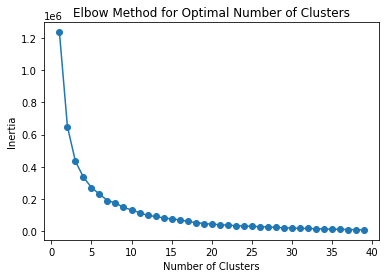

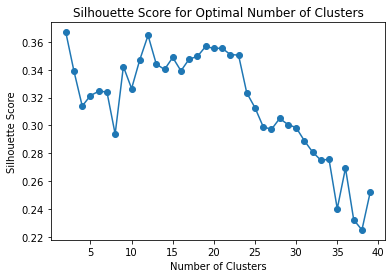

In [11]:
inertia = []

# Define a range of cluster numbers to test
cluster_range = range(1, 40)

# Calculate inertia for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data_clustering_depart[["duree_moyenne",'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Create an empty list to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
cluster_range = range(2, 40)  # Start with a minimum of 2 clusters

# Calculate silhouette scores for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_clustering_depart[["duree_moyenne",'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']])
    silhouette_avg = silhouette_score(data_clustering_depart[["duree_moyenne",'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

On prend donc 12 clusters

In [ ]:
# Fit k-means on 12 clusters
kmeans = KMeans(n_clusters=12, random_state=0)
cluster_labels = kmeans.fit_predict(data_clustering_depart[["duree_moyenne",'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']])
data_clustering_depart['cluster'] = cluster_labels

### Gare d'arrivée

In [12]:
data_clustering_arrivee = data[data['year'] < 2023]

data_clustering_arrivee = data_clustering_arrivee.groupby('gare_arrivee').agg({'duree_moyenne': 'mean',
                                         'nb_train_prevu': 'mean',
                                         'nb_train_retard_arrivee' :'mean',
                                         'retard_moyen_depart' : 'mean',
                                         'retard_moyen_tous_trains_depart': 'mean',
                                         'nb_train_retard_arrivee': 'mean',
                                         'retard_moyen_arrivee': 'mean',
                                         'retard_moyen_tous_trains_arrivee' : 'mean'}).reset_index()

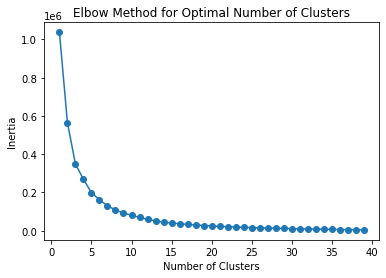

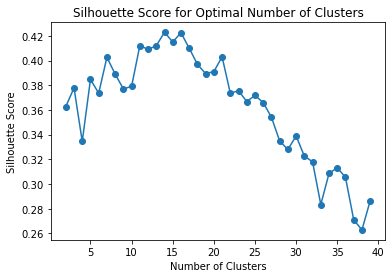

In [13]:
inertia = []

# Define a range of cluster numbers to test
cluster_range = range(1, 40)

# Calculate inertia for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data_clustering_arrivee[["duree_moyenne",'nb_train_prevu', 'nb_train_retard_arrivee','retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Create an empty list to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
cluster_range = range(2, 40)  # Start with a minimum of 2 clusters

# Calculate silhouette scores for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_clustering_arrivee[["duree_moyenne",'nb_train_prevu', 'nb_train_retard_arrivee','retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee']])
    silhouette_avg = silhouette_score(data_clustering_arrivee[["duree_moyenne",'nb_train_prevu', 'nb_train_retard_arrivee','retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

On prend donc 14 clusters

In [ ]:
# Fit k-means on 14 clusters
kmeans = KMeans(n_clusters=14)
cluster_labels = kmeans.fit_predict(data_clustering_arrivee[["duree_moyenne",'nb_train_prevu', 'nb_train_retard_arrivee','retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee']])
data_clustering_arrivee['cluster'] = cluster_labels

### Encodage des gares

In [ ]:
data['gare_depart_encoded'] = data['gare_depart'].map(data_clustering_depart.set_index('gare_depart')['cluster'])
data['gare_arrivee_encoded'] = data['gare_arrivee'].map(data_clustering_arrivee.set_index('gare_arrivee')['cluster'])

# Séparer les données d'entraînement et de test
train_data = data[data['year'] < 2023]
test_data = data[data['year'] == 2023]

test_data=test_data.reset_index()

# Dans le dataset de test, on ajoute les pourcentage de causes obtenues via clustering
for col in features_cause:
    test_data[col]=None

for i in range(len(test_data)):
    instance=test_data.iloc[i]
    cluster_ligne=int(data_clustering["cluster"][data_clustering.couple_gares==instance["couple_gares"]])
    for col in features_cause:
        test_data.at[i, col]=barycentres[col][barycentres.cluster==cluster_ligne]

# Colonnes d'entrée
features = ['year', 'month', 'gare_depart_encoded', 'gare_arrivee_encoded', 'nb_train_prevu','duree_moyenne']
features_avec_causes=features+features_cause
# Colonnes cible
target = 'retard_moyen_arrivee'

X_train_data=train_data[features_avec_causes]
y_train_data=train_data[target]

X_test_data=test_data[features_avec_causes]
y_test_data=test_data[target]



# 3. Selection du meilleur modèle et résultat

In [ ]:
N=100
mae_tab=np.zeros(N)
estimators=range(1,N+1)

for i in estimators:

    random_forest_model = RandomForestRegressor(n_estimators=i,max_features= 0.4, max_samples= 0.1)
    random_forest_model.fit(X_train_data, y_train_data)

    # Prédiction sur l'ensemble de test
    y_pred = random_forest_model.predict(X_test_data)

    # Évaluer la performance du modèle (par exemple, RMSE)
    rmse = mean_squared_error(y_test_data, y_pred, squared=False)
    mae = mean_absolute_error(y_test_data, y_pred)
    mae_tab[i-1]=mae

plt.plot(estimators, mae_tab)
plt.title("MAE en fontion du nombre d'estimateurs")
plt.show()

print(f'RMSE: {rmse} ')
print(f'MAE: {mae} ')

In [ ]:
 pgrid = {"max_samples": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
      "max_features": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

grid_search=GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid=pgrid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_data, y_train_data)

# Prédiction sur l'ensemble de test
y_pred = grid_search.best_estimator_.predict(X_test_data)

# Évaluer la performance du modèle (par exemple, RMSE)
rmse = mean_squared_error(y_test_data, y_pred, squared=False)
mae = mean_absolute_error(y_test_data, y_pred)

print(f'Best model RMSE: {rmse} ')
print(f'Best model MAE: {mae} ')

print(f'Best model params: {grid_search.best_params_} ')


In [ ]:
# Récupérer l'importance des features
feature_importances =random_forest_model.feature_importances_
feature_names = X_train_data.columns

# Créer un DataFrame pour une visualisation plus facile
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Trier les features par importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Tracer l'importance des features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importance des Features dans le modèle Random Forest')
plt.show()

# 4. Adaptation de la stratégie et résultat